Text(0, 0.5, 'Expression Level')

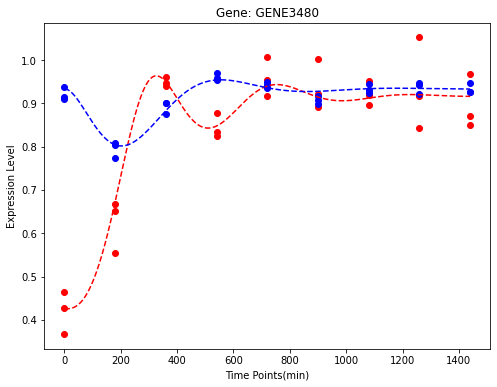

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

gene = "GENE3480"

Sp_star = np.load(f'./Sp_{gene}.npy')
Un_star = np.load(f'./Un_{gene}.npy')

ground_truth_Sp = np.load(f'./Sp_ground_truth_{gene}.npy')
ground_truth_Un = np.load(f'./Un_ground_truth_{gene}.npy')
alpha_ground_truth = np.load(f'./alpha_ground_truth_{gene}.npy')
bete_ground_truth = np.load(f'./bete_ground_truth_{gene}.npy')
gamma_ground_truth = np.load(f'./gamma_ground_truth_{gene}.npy')

t_points = torch.linspace(0, 24, 1441) 
obs_indices = torch.arange(0, 1441, 180) # in minutes
t_obs = t_points[obs_indices]  # in hours

plt.figure(figsize=(8, 6))
plt.plot(obs_indices, Sp_star, 'ro', label='Sp')
plt.plot(obs_indices, Un_star, 'bo', label='Un')
plt.plot(ground_truth_Sp, 'r--', label='Sp Ground Truth')
plt.plot(ground_truth_Un, 'b--', label='Un Ground Truth')
plt.title(f'Gene: {gene}')
plt.xlabel('Time Points(min)')
plt.ylabel('Expression Level')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt

class NN_k1(nn.Module):
    def __init__(self):
        super().__init__()
        # same as RVINN
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        if t.ndim == 0:
            # for training with torchdiffeq solver
            t = t.unsqueeze(0).unsqueeze(1)
        elif t.ndim == 1:
            # for inference
            t = t.unsqueeze(1)

        return F.softplus(self.net(t)) # should be positive, same as RVINN

class NN_k3(nn.Module):
    def __init__(self):
        super().__init__()
        # same as RVINN
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        if t.ndim == 0:
            # for training with torchdiffeq solver
            t = t.unsqueeze(0).unsqueeze(1)
        elif t.ndim == 1:
            # for inference
            t = t.unsqueeze(1)

        return F.softplus(self.net(t)) # should be positive, same as RVINN


In [3]:
# default device is CPU to set the same as RVINN
device = torch.device('cpu')

# set seed 
seed = 0
torch.manual_seed(seed)

# Set the number of threads to use in PyTorch 
# Setting a single thread explicitly is recommended in executing array jobs on HPC clusters
torch.set_num_threads(1)

In [4]:
import time
# define the ODE system with time-dependent parameters
# an advaned implementation using torchdiffeq
class RNA_ODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.k1_net = NN_k1()
        self.log_k2 = nn.Parameter(torch.randn(1)) # laenearnable constant parameter
        self.k3_net = NN_k3()
        self.history = {
            'loss_DATA': [],
            'Adam_Itr': [],
            'wall_time': [],
            }

    def forward(self, t, y):
        Un = y[0]
        Sp = y[1]

        k2 = torch.exp(self.log_k2) # should be positive, same as RVINN

        if t.ndim == 0:
            k1 = self.k1_net(t).squeeze()
            k2 = k2.squeeze()        
            k3 = self.k3_net(t).squeeze()
    

        else:
            # for inference
            k1 = self.k1_net(t).squeeze(-1)        # shape=[N]
            k2 = torch.exp(self.log_k2).repeat(t.shape[0])  # shape: [N], repeat
            k3 = self.k3_net(t).squeeze(-1)

        dUn_dt = k1 - k2 * Un
        dSp_dt = k2 * Un - k3 * Sp

        return torch.stack([dUn_dt, dSp_dt])
    
    def solve_ode(self, y0, t):
        sol = odeint(self, y0, t) # using default solver
        return sol

In [5]:
def plot_fitting(model, t_points, y0, Sp_star, Un_star, Sp_true, Un_true, gene):
    y_pred = model.solve_ode(y0, t_points).detach().numpy()
    t_np = t_points.detach().numpy()
    Sp_star_np = Sp_star.detach().numpy()
    Un_star_np = Un_star.detach().numpy()

    Sp_true_np = Sp_true
    Un_true_np = Un_true

    obs_indices = torch.arange(0, 1441, 180) 
    t_obs = t_np[obs_indices.numpy()]  

    plt.figure()
    plt.plot(t_np, y_pred[:, 0], "c-", label="pred Un")
    plt.plot(t_np, Un_true_np, 'b', label="true Un")  
    plt.plot(t_obs, Un_star_np, 'bx', label="obs Un" )
    plt.title(f"{gene}- Un(t)")
    plt.xlabel("Time (h)")
    plt.ylabel("Un")
    plt.show()

    plt.figure()
    plt.plot(t_np, y_pred[:, 1], "m-", label="pred Sp")
    plt.plot(t_np, Sp_true_np, 'r', label="true Sp")
    plt.plot(t_obs, Sp_star_np, 'rx', label="obs Sp")
    plt.title(f"{gene}- Sp(t)")
    plt.xlabel("Time (h)")
    plt.ylabel("Sp")
    plt.show()


Epoch    0 | Loss = 0.248532 | Wall Time = 0.20 sec


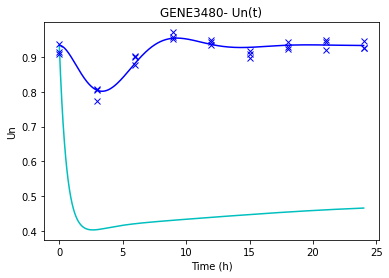

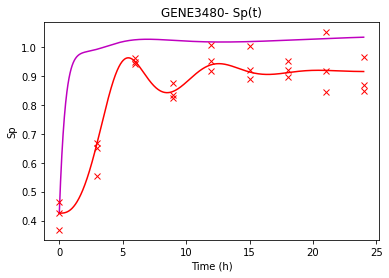

Epoch  300 | Loss = 0.004121 | Wall Time = 63.53 sec


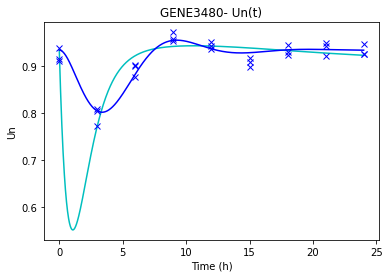

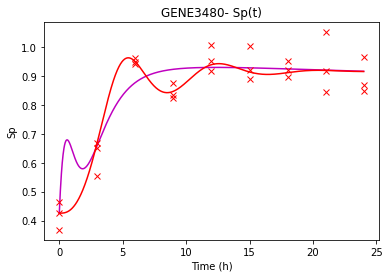

Epoch  600 | Loss = 0.003795 | Wall Time = 124.30 sec


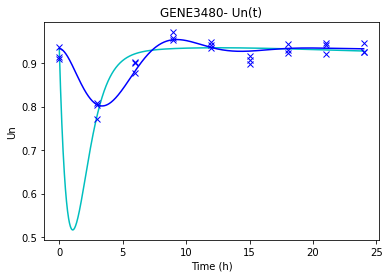

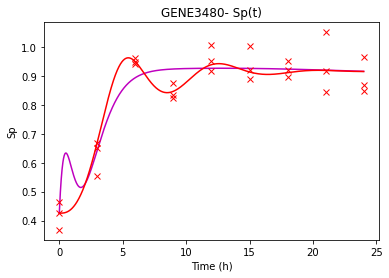

Epoch  900 | Loss = 0.003665 | Wall Time = 185.53 sec


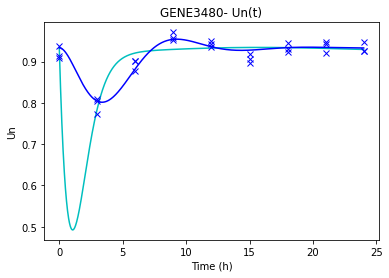

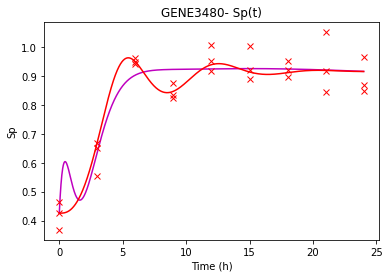

Epoch 1200 | Loss = 0.003568 | Wall Time = 250.86 sec


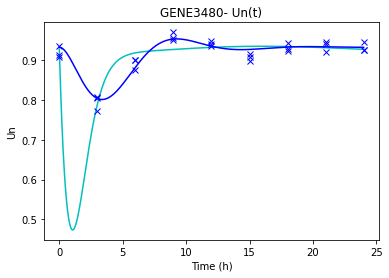

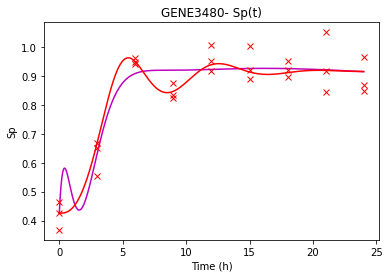

Epoch 1500 | Loss = 0.003468 | Wall Time = 318.70 sec


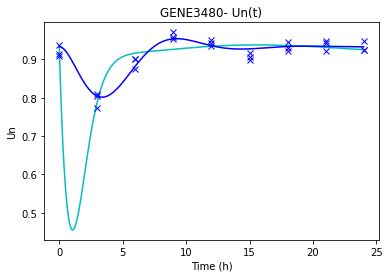

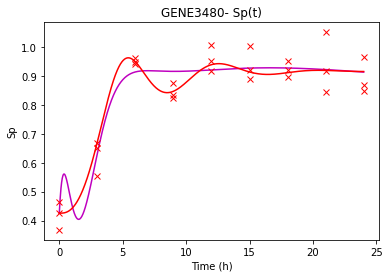

Epoch 1800 | Loss = 0.003355 | Wall Time = 388.10 sec


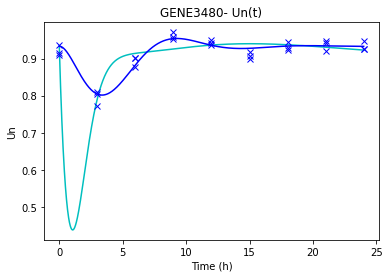

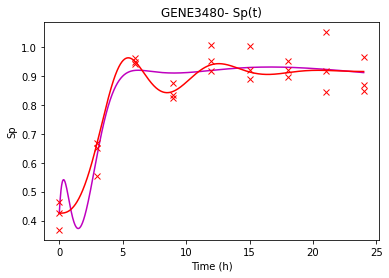

Epoch 2100 | Loss = 0.003199 | Wall Time = 459.05 sec


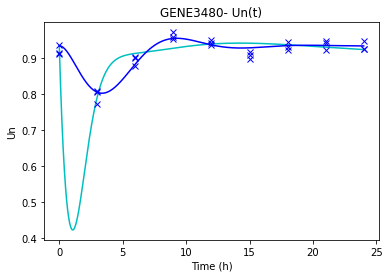

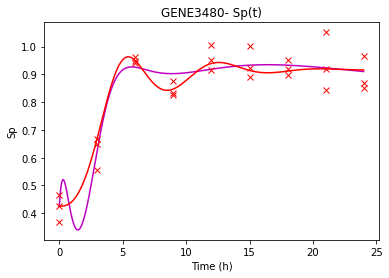

Epoch 2400 | Loss = 0.002975 | Wall Time = 532.87 sec


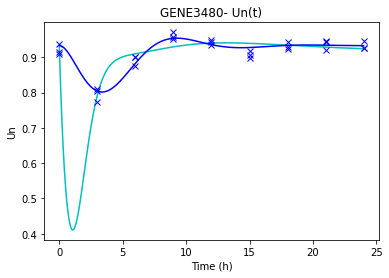

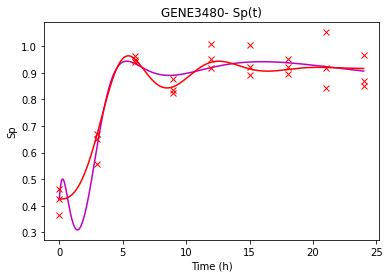

Epoch 2700 | Loss = 0.002783 | Wall Time = 611.82 sec


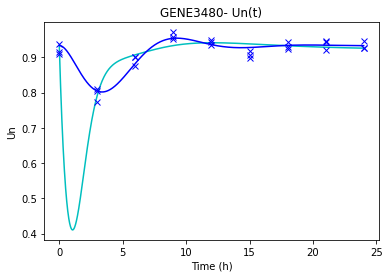

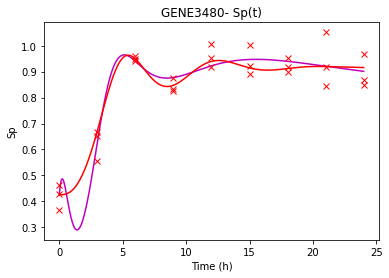

In [8]:
# given the ground truth initial values
y0 = torch.tensor([ground_truth_Un[0], ground_truth_Sp[0]], dtype=torch.float32)

Sp_star_torch = torch.tensor(Sp_star, dtype=torch.float32)
Un_star_torch = torch.tensor(Un_star, dtype=torch.float32)


node = RNA_ODE()
optimizer = optim.Adam(node.parameters(), lr=1e-3)
num_epochs = 3000
start_time = time.time()

for epoch in range(num_epochs):
    optimizer.zero_grad()

    y_pred_obs = node.solve_ode(y0, t_obs)  
    
    Un_pred_obs = y_pred_obs[:, 0]
    Sp_pred_obs = y_pred_obs[:, 1]

    Sp_pred_obs = Sp_pred_obs.unsqueeze(1) 
    Un_pred_obs = Un_pred_obs.unsqueeze(1) 

    loss = torch.mean((Sp_pred_obs - Sp_star_torch)**2) + torch.mean((Un_pred_obs - Un_star_torch)**2)

    loss.backward()
    optimizer.step()

    node.history['loss_DATA'].append(loss.item())
    node.history['Adam_Itr'].append(epoch)
    wall_time = time.time() - start_time
    node.history['wall_time'].append(wall_time)
    if epoch == 0 or epoch % 300 == 0:
        ### this plot is just for your information, we did not run this in benchmarking
        print(f"Epoch {epoch:4d} | Loss = {loss.item():.6f} | Wall Time = {wall_time:.2f} sec") 
        plot_fitting(node, t_points, y0, Sp_star_torch, Un_star_torch, ground_truth_Sp, ground_truth_Un, gene)


In [10]:
def plot_kinetic_parameters(model, t_points, k1_ground_truth, k2_ground_truth, k3_ground_truth):
    t_np = t_points.detach().numpy()

    with torch.no_grad():
        k1 = model.k1_net(t_points).squeeze(-1)
        k2_value = torch.exp(model.log_k2).squeeze()
        k2 = k2_value.repeat(t_points.shape[0])
        k3 = model.k3_net(t_points).squeeze(-1)

    # NumPy
    k1_np = k1.numpy().flatten()
    k2_np = k2.numpy().flatten()
    k3_np = k3.numpy().flatten()

    plt.figure()
    plt.plot(t_np, k1_np, "r--", label="alpha(t)")
    plt.plot(t_np, k1_ground_truth, 'r-', label="alpha ground truth")
    plt.legend()
    plt.title("alpha(t)")
    plt.xlabel("Time")
    plt.ylabel("alpha")
    plt.show()

    plt.figure()
    plt.plot(t_np, k2_np, "k--", label="beta(t)")
    plt.plot(t_np, k2_ground_truth, 'k-', label="beta ground truth")
    plt.legend()
    plt.title("beta(t)")
    plt.xlabel("Time")
    plt.ylabel("beta")
    plt.show()

    plt.figure()
    plt.plot(t_np, k3_np, "b--", label="gamma(t)")
    plt.plot(t_np, k3_ground_truth, 'b-', label="gamma ground truth")
    plt.legend()
    plt.title("gamma(t)")
    plt.xlabel("Time")
    plt.ylabel("gamma")
    plt.show()

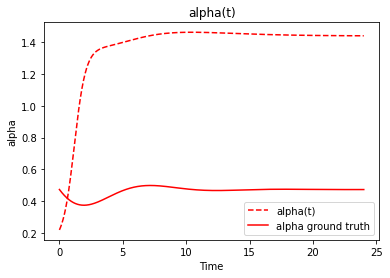

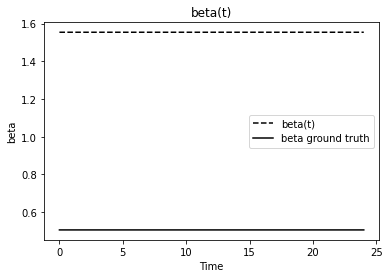

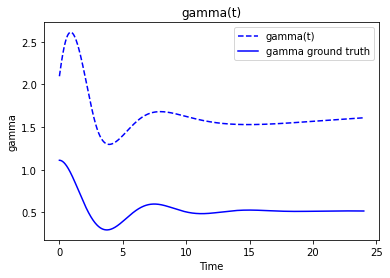

In [11]:
plot_kinetic_parameters(node, t_points, alpha_ground_truth, bete_ground_truth, gamma_ground_truth)